## Homework

---

### Q1

Convert your **Gibbs sampler** from the previous homework to be a **Metropolis within Gibbs** sampler. 
- Do not derive any full conditionals and instead just use the joint distribution which is the product of the likelihood with the priors 
    - Note that in fact you must only be proportional to the joint since irrelevant priors of "the other parameter" will cancel in the ratio
- Note that $\tau$ must be positive so proposals $\tilde \tau$ must also be positive. The easiest way to achieve this would be to use independent samples (that do not depend on $\tau^{(t-1)}$ from exponential, half normal, gamma, or inverse gamma distributions (and other distributions defining strictly positive random variables).
- When considering using independent proposal distributions one option of some note is to use the prior $p(\tau)$ as this proposal distribution

*Clearly articulate your specification and provide a demonstration showing the Bayesian inference it provides, in contrast to that of your previous Gibbs sampler (of Q2 from the last homework).*


In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

n = 30; m = 9; s = 0.2 ; x = stats.norm(loc=m, scale=s).rvs(size=n)

# Metropolis within Gibbs parameters
C, G = 2, 10000  # Number of chains, Number of Gibbs samples
theta, tau = np.zeros([C, G]), np.zeros([C, G])
theta[:, 0] = np.mean(x)
tau[:, 0] = 1/np.var(x)

# Proposal standard deviations
sigma_theta = 1.0   
shape_tau = n/2 + 1 

def joint_log_prob(theta, tau, x):
    """ Compute log of joint distribution p(x | theta, tau) * p(theta, tau) """
    return (n/2) * np.log(tau) - (tau/2) * np.sum((x - theta)**2)

for c in range(C):
    for g in range(1, G):
        # Metropolis update for theta
        theta_prop = stats.norm(loc=theta[c, g-1], scale=sigma_theta).rvs()
        log_accept_ratio = joint_log_prob(theta_prop, tau[c, g-1], x) - joint_log_prob(theta[c, g-1], tau[c, g-1], x)
        if np.log(np.random.rand()) < log_accept_ratio:
            theta[c, g] = theta_prop
        else:
            theta[c, g] = theta[c, g-1]

        # Metropolis update for tau
        tau_prop = stats.gamma(a=5, scale=2).rvs()
        log_accept_ratio = joint_log_prob(theta[c, g], tau_prop, x) - joint_log_prob(theta[c, g], tau[c, g-1], x)
        if np.log(np.random.rand()) < log_accept_ratio:
            tau[c, g] = tau_prop
        else:
            tau[c, g] = tau[c, g-1]


accepted_theta = np.sum(theta[:, 1:] != theta[:, :-1]) / G
accepted_tau = np.sum(tau[:, 1:] != tau[:, :-1]) / G
print("Theta acceptance rate:", accepted_theta)
print("Tau acceptance rate:", accepted_tau)

Theta acceptance rate: 0.1093
Tau acceptance rate: 0.4172


theta estimate 0:  9.033006770962189
95% credible interval:  [8.94279732 9.1173304 ]
theta estimate 1:  9.035320363228138
95% credible interval:  [8.94275779 9.12919471]
SD estimate 0:  0.24485205398048115
95% credible interval:  [0.1957099  0.30696989]
SD estimate 1:  0.24370869401120282
95% credible interval:  [0.19708602 0.3045853 ]


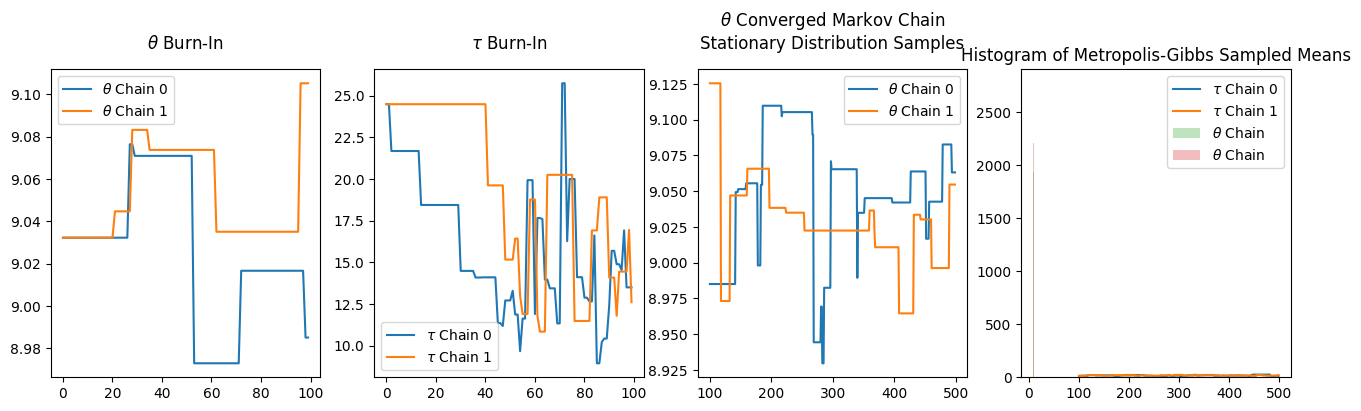

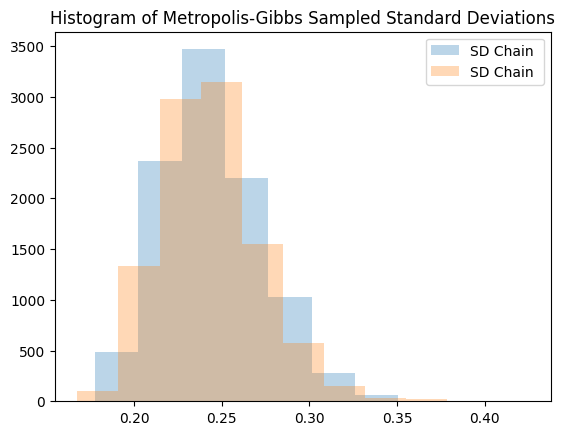

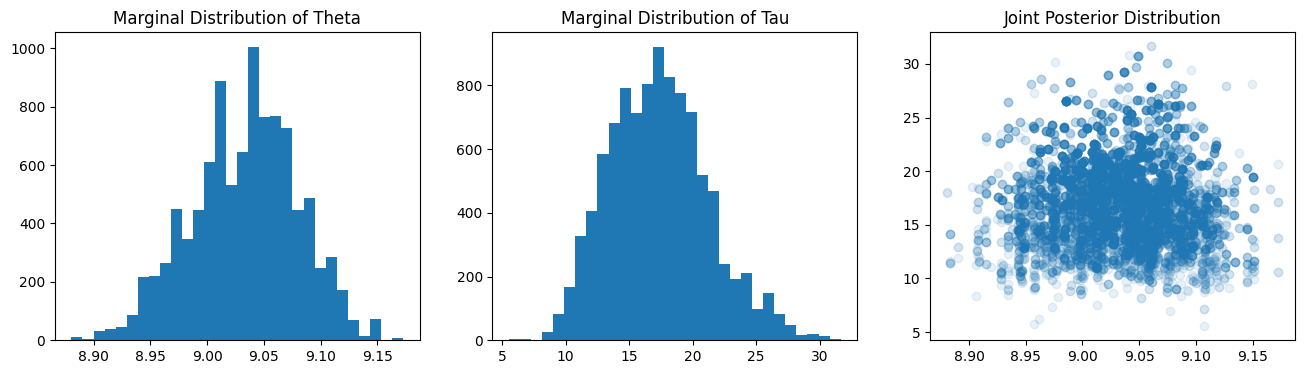

In [24]:
# Plot burn-in and convergence
fig, ax = plt.subplots(1, 4, figsize=(16,4))
ax[0].set_title("$\\theta$ Burn-In", pad=15)
ax[1].set_title("$\\tau$ Burn-In", pad=15)
ax[2].set_title("$\\theta$ Converged Markov Chain\nStationary Distribution Samples", pad=15)
ax[3].set_title("$\\tau$ Converged Markov Chain\nStationary Distribution Samples", pad=15)

burn = 100  
demo = 500 

for c in range(C):
    ax[0].plot(theta[c, :burn], label="$\\theta$ Chain "+str(c))
    ax[1].plot(tau[c, :burn], label="$\\tau$ Chain "+str(c))
    ax[2].plot(np.arange(burn, demo, dtype=int), theta[c, burn:demo], label="$\\theta$ Chain "+str(c))
    ax[3].plot(np.arange(burn, demo, dtype=int), tau[c, burn:demo], label="$\\tau$ Chain "+str(c))

ax[0].legend(); ax[1].legend(); ax[2].legend(); ax[3].legend();

# Posterior estimation and credible intervals
plt.hist(theta[0, burn:], alpha=0.3, label=("$\\theta$ Chain ",0))
print("theta estimate 0: ", theta[0, burn:].mean())
print("95% credible interval: ", np.quantile(theta[0, burn:], [0.025, 0.975]))

plt.hist(theta[1, burn:], alpha=0.3, label=("$\\theta$ Chain ",1))
print("theta estimate 1: ", theta[1, burn:].mean())
print("95% credible interval: ", np.quantile(theta[1, burn:], [0.025, 0.975]))

plt.title("Histogram of Metropolis-Gibbs Sampled Means")
plt.legend()

# Posterior estimation for standard deviation
plt.figure()
plt.hist(1/(tau[0, burn:])**0.5, alpha=0.3, label=("SD Chain ", 0))
print("SD estimate 0: ", (1/(tau[0, burn:])**0.5).mean())
print("95% credible interval: ", np.quantile(1/(tau[0, burn:])**0.5, [0.025, 0.975]))

plt.hist(1/(tau[1, burn:])**0.5, alpha=0.3, label=("SD Chain ", 1))
print("SD estimate 1: ", (1/(tau[1, burn:])**0.5).mean())
print("95% credible interval: ", np.quantile(1/(tau[1, burn:])**0.5, [0.025, 0.975]))

plt.title("Histogram of Metropolis-Gibbs Sampled Standard Deviations")
plt.legend()

plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plt.hist(theta[0, burn:], bins=30)
plt.title("Marginal Distribution of Theta")

plt.subplot(1, 3, 2)
plt.hist(tau[0, burn:], bins=30)
plt.title("Marginal Distribution of Tau")

plt.subplot(1, 3, 3)
plt.scatter(theta[0, burn:], tau[0, burn:], alpha=0.1)
plt.title("Joint Posterior Distribution")
plt.show()



### Q2

Adjust your **Metropolis within Gibbs** sampler as follows.

- Use the following **dependent** proposal for $\tau$

```Python
stats.truncnorm(a=-tau_t_minus_1/s, b=np.Inf,
                loc=tau_t_minus_1, scale=s)
```

- Use a prior for $\theta$ that is not a normal distribution 


*Provide a demonstration showing the Bayesian inference provided by this sampler. Then discuss the necessity (or lackthereof)  of analytically determining the full conditional distributions when using Metropolis-Hastings.*


Theta acceptance rate: 0.1657
Tau acceptance rate: 1.9517


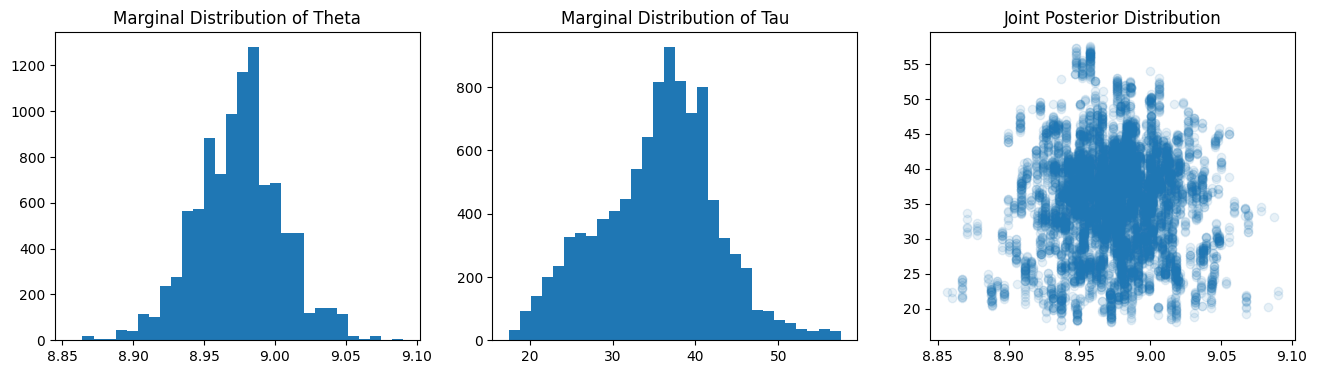

In [33]:
n = 30; m = 9; s = 0.2; x = stats.norm(loc=m, scale=s).rvs(size=n)

# Metropolis within Gibbs parameters
C, G = 2, 10000 
theta, tau = np.zeros([C, G]), np.zeros([C, G])
theta[:, 0] = np.mean(x)  
tau[:, 0] = 1 / np.var(x)  

# Proposal standard deviations
sigma_theta = 0.5 
shape_tau = n / 2 + 1

# Define the Joint Log Probability
def joint_log_prob(theta, tau, x):
    """Compute log of joint distribution p(x | theta, tau) * p(theta, tau)."""
    prior_theta = stats.uniform(loc=5, scale=10).pdf(theta)  # Uniform Prior U(5,15)
    log_prior_theta = np.log(prior_theta) if prior_theta > 0 else -np.inf
    return log_prior_theta + (n / 2) * np.log(tau) - (tau / 2) * np.sum((x - theta) ** 2)

# Metropolis within Gibbs Sampler
for c in range(C):
    for g in range(1, G):
        # Metropolis update for theta (Non-Normal Prior)
        theta_prop = stats.norm(loc=theta[c, g-1], scale=sigma_theta).rvs()
        
        if 5 <= theta_prop <= 15:  # Enforce uniform prior support
            log_accept_ratio = joint_log_prob(theta_prop, tau[c, g-1], x) - joint_log_prob(theta[c, g-1], tau[c, g-1], x)
            if np.log(np.random.rand()) < log_accept_ratio:
                theta[c, g] = theta_prop
            else:
                theta[c, g] = theta[c, g-1]
        else:
            theta[c, g] = theta[c, g-1]  # Reject proposals outside prior bounds

        # Metropolis update for tau (Truncated Normal Proposal)
        tau_t_minus_1 = tau[c, g-1]
        tau_prop = stats.truncnorm(a=-tau_t_minus_1 / s, b=np.inf, loc=tau_t_minus_1, scale=s*3).rvs()
        
        log_accept_ratio = joint_log_prob(theta[c, g], tau_prop, x) - joint_log_prob(theta[c, g], tau[c, g-1], x)
        if np.log(np.random.rand()) < log_accept_ratio:
            tau[c, g] = tau_prop
        else:
            tau[c, g] = tau[c, g-1]

# Compute acceptance rates
accepted_theta = np.sum(theta[:, 1:] != theta[:, :-1]) / G
accepted_tau = np.sum(tau[:, 1:] != tau[:, :-1]) / G
print("Theta acceptance rate:", accepted_theta)
print("Tau acceptance rate:", accepted_tau)

# Visualization
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plt.hist(theta[0, 100:], bins=30)
plt.title("Marginal Distribution of Theta")

plt.subplot(1, 3, 2)
plt.hist(tau[0, 100:], bins=30)
plt.title("Marginal Distribution of Tau")

plt.subplot(1, 3, 3)
plt.scatter(theta[0, 100:], tau[0, 100:], alpha=0.1)
plt.title("Joint Posterior Distribution")

plt.show()

Discussion:

When using Metropolis-Hasting, we don't need to derive the full conditionals and can sample from the joint. This is good when the full conditionals are hard to derive or unknown. However, Metropolis-Hasting is less efficient if the proposals are not good.


### Q3 

For **Metropolis Hastings** targetting (**stationary distribution**) $p$ based on proposal distribuiton $q$ given below

$\begin{align}
q(\tilde x^{(t)} | x^{(t-1)}) &={} \left(\frac{1}{2}\right)^{1-{\tilde x^{(t)}}}\left(\frac{1}{2}\right)^{\tilde x^{(t)}} \quad \color{gray}{\textrm{ ... does } \quad \frac{q(x^{(t-1)}|\tilde x^{(t)})}{q(\tilde x^{(t)}|x^{(t-1)})} \quad  \textrm{ cancel?}}\\
\textrm{and} \quad p(x^{(t)}) &={} \left(\frac{1}{3}\right)^{1-{x^{(t)}}}\left(\frac{2}{3}\right)^{x^{(t)}}\\
\end{align}$

<u>show that</u> the **transition kernel** $K$ of transition probabilities is defined the **Metropolis Hastings** algorithm is

$K = \left[\begin{array}{cc}\Pr(x^{(t)}=0 \rightarrow x^{(t+1)}=0) & \Pr(x^{(t)}=1 \rightarrow x^{(t+1)}=0)\\\Pr(x^{(t)}=0 \rightarrow x^{(t+1)}=1)& \Pr(x^{(t)}=1 \rightarrow x^{(t+1)}=1)\end{array}\right] = \left[\begin{array}{cl} 0.5 & 0.25 \\ 0.5 & 0.75 \end{array}\right]$


This means that

- if we're currently a $0$ there's a 50\% chance that we'll stay a $0$ and 50\% chance that we'll change to a $1$
- and if we're currently a $1$ there's a 75\% chance that we'll stay a $1$ and 25\% chance that we'll change to a $0$

which specifies [geometric distributions](https://en.wikipedia.org/wiki/Geometric_distribution) with, respectively, expected values of $1$ and $3$ "failures before transitioning to the other state" which means that on average a "$0$ state" will be a run of two $0$'s while a "$1$ state" will be a run of four $1$'s which leads to the desired one-to-two (or one-thirds to two-thirds) ratio of $0$'s and $1$ is the Markov Chain. 


The proposal distribution is given as 
\begin{align*}q(\tilde x^{(t)} | x^{(t-1)}) &={} \left(\frac{1}{2}\right)^{1-{\tilde x^{(t)}}}\left(\frac{1}{2}\right)^{\tilde x^{(t)}}\end{align*}

since it's symmetric, we can write 
\begin{align*} q(x^{(t-1)} | \tilde x^{(t)}) = q(\tilde x^{(t)} | x^{(t-1)})\end{align*}

the Metropolis-Hasting acceptance probability is
\begin{align*}\alpha = min(1, \frac{p(\tilde x^{(t)})q(x^{(t-1)} | \tilde x^{(t)})}{p(x^{(t-1)})q(\tilde x^{(t)} | x^{(t-1)})}) \end{align*}
since q is symmetric, we can cancel it out and leaves us with
\begin{align*}\alpha = min(1, \frac{p(\tilde x^{(t)})}{p(x^{(t-1)})}) \end{align*}

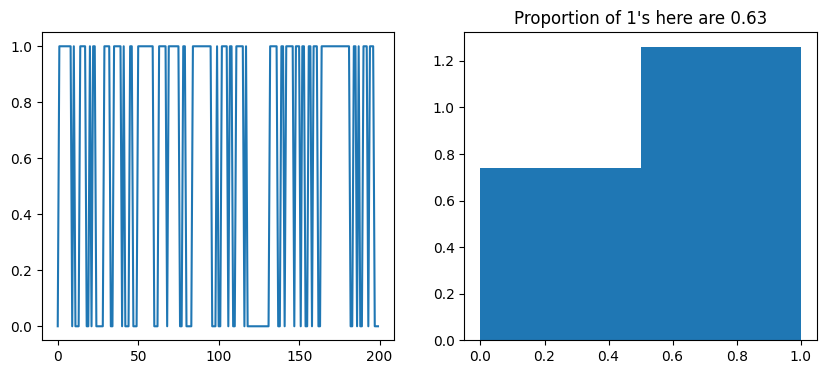

In [29]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

# Here's what it looks like if we flip coins  
# with transition probabilties defind by A sequentially
# and sure enough we recover 1/3 and 2/3 for 0 and 1 respectively
K = np.array([[.5,.25],[.5,.75]]) 
T = 200
s_t = np.zeros(T, dtype=int)
for t in range(1, T):
    s_t[t] = int(stats.uniform().rvs() < K[:,s_t[t-1]][1])
    
fig,ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].plot(s_t)
ax[1].hist(s_t, bins=2, density=True)
ax[1].set_title("Proportion of 1's here are "+str(s_t.mean()));

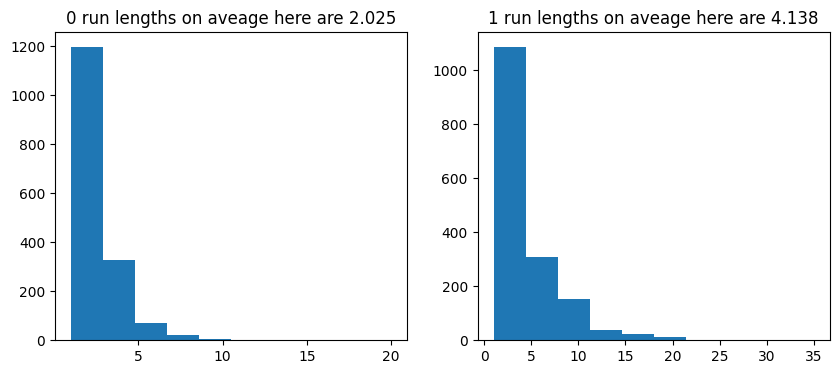

In [30]:
# Here's what it looks like if we flip coins  
# with transition probabilties defind by K 
# and sure enough we recover 1/3 and 2/3 for 0 and 1 respectively
T = 10000
s_t = np.zeros(T, dtype=int)
for t in range(1, T):
    s_t[t] = int(stats.uniform().rvs() < K[:,s_t[t-1]][1])
    
state0_run_length = []
state1_run_length = []
run_length = 1
for t in range(1,T):
    if s_t[t]==s_t[t-1]:
        run_length += 1
    else:
        if s_t[t-1] == 0:
            state0_run_length += [run_length]
        else:
            state1_run_length += [run_length]        
        run_length = 1
        
fig,ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].hist(state0_run_length)
ax[0].set_title("0 run lengths on aveage here are "+str(np.mean(state0_run_length).round(3)))
ax[1].hist(state1_run_length)
ax[1].set_title("1 run lengths on aveage here are "+str(np.mean(state1_run_length).round(3)));
